In [1]:
import pandas as pd
import os
import re
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

# Create initial datasets

### Setup input/output

In [2]:
# set base directory
#baseDIR = '/mnt/d'
baseDIR = 'T:/'

# set input directory
#inDIR = 'TBNG/data/'
inDIR = "2-Projects/Thunder Basin/Weight Gains Project/DATA/Vegetation DATA/"

# set input file
vorXLSX = 'VOR/weight gains VORmetadata7March2022_ep.xlsx'
bmXLSX = 'biomass and FQ/wt gains biomass and FQ 7March2022_ep.xlsx'

# set working directory to project directory
os.chdir(os.path.dirname(os.getcwd()))

# set directory of shapefile with location data
inSHP = 'data/shps/TB_wGain_sampling_2021_fixed_20220607.shp'

# set output directories
outDIR_clip = 'data/clip'
outDIR_vor = 'data/vor'
outDIR_vor_train = 'data/vor_train'
if not os.path.exists(os.path.join(os.getcwd(), outDIR_clip)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_clip))
if not os.path.exists(os.path.join(os.getcwd(), outDIR_vor)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_vor))
if not os.path.exists(os.path.join(os.getcwd(), outDIR_vor_train)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_vor_train))

### Load data

In [3]:
# create an Excel file object for investigating contents
vor_xlsx = pd.ExcelFile(os.path.join(baseDIR, inDIR, vorXLSX))
# display the sheet names in the .xlsx file
display(vor_xlsx.sheet_names)

['Sheet1']

In [4]:
# create an Excel file object for investigating contents
bm_xlsx = pd.ExcelFile(os.path.join(baseDIR, inDIR, bmXLSX))
# display the sheet names in the .xlsx file
display(bm_xlsx.sheet_names)

['Summary by Pasture', 'Raw Data']

In [5]:
# Create the desired dataframes by parsing the individual sheets
df_wtgn_bm = bm_xlsx.parse(sheet_name='Raw Data', header=0)
df_wtgn_vor = vor_xlsx.parse(sheet_name='Sheet1', header=0)

In [6]:
gdf_wtgn = gpd.read_file(inSHP)

# Biomass dataset

#### Clean up dates

In [7]:
df_wtgn_bm['Date'] = pd.to_datetime(df_wtgn_bm['Date'])

### Prep biomass values for joining

In [8]:
# drop data with missing plot info
df_wtgn_bm = df_wtgn_bm[df_wtgn_bm['Plot'] != 'na']
# convert plot values to integer to match VOR
df_wtgn_bm.loc[:,'Plot'] = df_wtgn_bm['Plot'].astype(int) 

In [9]:
# drop any missing data
df_wtgn_bm = df_wtgn_bm[df_wtgn_bm['Total g/m^2'].notnull()]
# rename weight column to match other datasets
df_wtgn_bm = df_wtgn_bm.rename(columns={'Total g/m^2': 'Total Weight (g/m^2)'})
# rename pastures where necessary
bm_past_dict = {
    'Mid Weiss G': 'Mid Weiss Pasture G'
}
df_wtgn_bm.loc[:, 'Pasture'] = df_wtgn_bm['Pasture'].apply(lambda x: bm_past_dict[x] if x in bm_past_dict else x)

### Visualize data to check that it makes sense

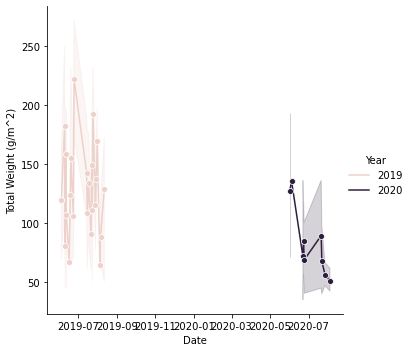

In [10]:
# plot pin-frame calibration data
sns.relplot(x='Date', y='Total Weight (g/m^2)', hue='Year',
            data=df_wtgn_bm, kind='line', marker="o")

### Add in GPS locations from shapefile

In [11]:
# update prairie dog colony column
df_wtgn_bm = df_wtgn_bm.rename(columns={'PD Colony?': 'PD'})
df_wtgn_bm.loc[:, 'PD'] = df_wtgn_bm['Pasture'].transform(lambda x: 'Yes' if '-PD' in x else 'No')

In [12]:
past_name_dict = {
    'Mid Weiss Pasture G': 'East Weiss',
    'North Owens -PD': 'North Owens', 
    'North Owens - No PD': 'North Owens',
    'Mid Weiss Pasture K': 'East Weiss',
    'East NE Weiss': 'East Weiss', 
    'Cameron  Place': 'Cameron Place',
    'North School Section H': 'East Weiss',
    'East Weiss K': 'East Weiss', 
    'SW Section 4': 'Section 4',
    'W Weiss E': 'West Weiss',
    'Section 4': 'Section 4', 
    'W Weiss C': 'West Weiss'
}

# create unique id's of pasture+plot+PD that match for shape and clip data.
df_wtgn_bm.loc[:, 'Pasture_shp'] = df_wtgn_bm['Pasture'].transform(
    lambda x: past_name_dict[x] if x in past_name_dict.keys() else x)
df_wtgn_bm.loc[:, 'Pasture_shp'] = df_wtgn_bm['Pasture_shp'].transform(
    lambda x: re.sub(' ', '_', x))
df_wtgn_bm.loc[:, 'Join_ID'] = df_wtgn_bm.apply(lambda x: '_'.join([x['Pasture_shp'], 
                                    'Pt' + str(x['Plot']),
                                    x['PD']]),
                 axis=1)#.Pasture.unique()

In [13]:
gdf_wtgn.loc[gdf_wtgn['pdog'].isnull(), 'pdog'] = 'No'

In [14]:
gdf_wtgn.loc[:, 'Join_ID'] = gdf_wtgn.apply(lambda x: '_'.join([x['Plot_ID'], x['pdog']]), axis=1)

In [15]:
gdf_wtgn['Mean.GPS_E.Biomass'] = gdf_wtgn.geometry.centroid.x
gdf_wtgn['Mean.GPS_N.Biomass'] = gdf_wtgn.geometry.centroid.y

In [16]:
df_wtgn_bm.Pasture.unique()

array(['Mid Weiss Pasture G', 'Center Owens', 'Section 8',
       'North Owens -PD', 'North Owens - No PD', 'Top',
       'Mid Weiss Pasture K', 'East NE Weiss', 'Cameron  Place',
       'North School Section H', 'East Weiss K', 'SW Section 4',
       'W Weiss E', 'Section 4', 'W Weiss C'], dtype=object)

In [17]:
df_wtgn_bm = pd.merge(df_wtgn_bm,
                      gdf_wtgn[['Join_ID', 'Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']],
                      on= 'Join_ID',
                      suffixes=['_clip', '_shp'],
                      how='left')

In [18]:
df_wtgn_bm.to_csv(os.path.join(os.getcwd(), outDIR_clip, 'TB_wtgn_clip.csv'), index=False)

# VOR

### *Additional cleaning*

In [11]:
# drop data with missing dates
df_wtgn_vor = df_wtgn_vor[~df_wtgn_vor['date'].isin(['nan', 'na', np.nan])]
# drop data with note about plot center
df_wtgn_vor = df_wtgn_vor[~(df_wtgn_vor['notes'].notnull() &
                           df_wtgn_vor['notes'].str.contains('2.5m across center of plot'))]

In [12]:
# convert date column to datetime object
df_wtgn_vor.loc[:, 'date'] = pd.to_datetime(df_wtgn_vor['date'])

# get subset of 2019 data to drop based solely on sample date
df_wtgn_vor_2019_bad = df_wtgn_vor[df_wtgn_vor['date'] <= datetime.datetime(2019, 6, 24)]

In [13]:
"""drop all data collected prior to 06/24/2019 and 
plots resampled in 2019 that were first sampled prior"""
# get unique pasture/plot/position combos that were sampled prior to 2019 cut-off date
vor_bad_ids = df_wtgn_vor_2019_bad.apply(lambda x: '_'.join([x['pasture'],
                                                             str(x['plot']),
                                                             x['VOR position'],
                                                             str(x['date'].year)]), axis=1)

# remove all matching id's from dataset
df_wtgn_vor = df_wtgn_vor[~df_wtgn_vor.apply(lambda x: '_'.join([x['pasture'],
                                      str(x['plot']),
                                      x['VOR position'],
                                      str(x['date'].year)]), axis=1).isin(vor_bad_ids)]

In [14]:
# convert all VOR readings > 90 cm to 90 cm and store as integers
df_wtgn_vor.loc[df_wtgn_vor['VOR'] == '>90', 'VOR'] = 90
df_wtgn_vor['VOR'] = df_wtgn_vor['VOR'].astype(int)

# create list of species to drop from VOR data
vor_spp_drop_list = ['ATCA', 'atca', 'OPPO', 'oppo', 'ARTR', 'artr', 'SD ARTR', 'ARCA', 'arca', 'SD ATCA']

# drop VOR readings in species list
df_wtgn_vor_spp_bad = df_wtgn_vor[df_wtgn_vor['species'].isin(vor_spp_drop_list)]

# get unique pasture/plot/position combos that were sampled prior to 2019 cut-off date
vor_bad_ids2 = df_wtgn_vor_spp_bad.apply(lambda x: '_'.join([x['pasture'],
                                                             str(x['plot']),
                                                             x['VOR position'],
                                                             str(x['date'])]), axis=1)

# remove all matching id's from dataset
df_wtgn_vor = df_wtgn_vor[~df_wtgn_vor.apply(lambda x: '_'.join([x['pasture'],
                                      str(x['plot']),
                                      x['VOR position'],
                                      str(x['date'])]), axis=1).isin(vor_bad_ids2)]

In [15]:
# remove all VOR values of -1
df_wtgn_vor = df_wtgn_vor[~df_wtgn_vor['VOR'] < 0]

In [16]:
# check species of any 0 value readings
df_wtgn_vor[df_wtgn_vor['VOR'].astype(int) < 1]['species'].unique()

array([nan, 'BARE', 'BRAR', 'BARE/MOSS', 'BOGR', 'PASM', 'ARPU', 'CADU',
       'SCPA', 'SPCO', 'BRTE', 'VUOC', 'POSE', 'MAGR', 'ASSP', 'HYFI',
       'LECI', 'CAFI', 'HECO', 'ERPA', 'AGCR', 'KOMA', 'TEAC', 'PLPA'],
      dtype=object)

In [17]:
# add 1 to all VOR readings that have a non-bare species value
df_wtgn_vor.loc[:, 'VOR'] = df_wtgn_vor.apply(
    lambda x: x['VOR'] if x['species'] in ['BARE', 
                                           'BARE/MOSS'] else x['VOR'] + 1, axis=1)

### *Additional prep*

In [18]:
# get mean of any repeat measurements within groups
df_wtgn_vor = df_wtgn_vor.groupby(['pasture', 'plot', 'date', 
                         'VOR position', 'reading (high/low)'])['VOR'].mean().reset_index()
# separate low and high VOR readings to separate columns
df_wtgn_vor = df_wtgn_vor.pivot(index=['pasture', 'plot', 'date', 
                         'VOR position'], 
                  columns='reading (high/low)', values='VOR').reset_index()
# rename columns to match other datasets
df_wtgn_vor = df_wtgn_vor.rename(columns={'low': 'Low_cm',
                                          'high': 'High_cm'})
# drop name associated with columns
df_wtgn_vor.columns.name = None

# drop VOR where low > high as suspected data entry errors
df_wtgn_vor = df_wtgn_vor[df_wtgn_vor['Low_cm'] <= df_wtgn_vor['High_cm']]

### *Combine with biomass dataset*

In [19]:
# create mapping of pasture names
vor_past_dict = {'NE cameron place': 'Cameron  Place',
             'SW section 4': 'SW Section 4',
             'center owens': 'Center Owens',
             'downey 5-6': None,
             'east NE weiss': 'East NE Weiss', 
             'east weiss K': 'East Weiss K', 
             'hogsback': 'Hogsback',
             'mid weiss G': 'Mid Weiss Pasture G',
             'mid weiss K': 'Mid Weiss Pasture K', 
             'mid weiss g': 'Mid Weiss Pasture G',
             'ne section 4': None, 
             'north owens': 'North Owens',
             'north owens PD': 'North Owens -PD',
             'north owens no PD': 'North Owens - No PD',
             'north school section': 'North School Section',
             'north school section H': 'North School Section H',
             'nw section 4': 'NW Section 4',
             'rattlesnake': 'Rattlesnake',
             'section 4': 'Section 4', 
             'section 8': 'Section 8',
             'section 9': 'Section 9', 
             'top': 'Top', 
             'upper rattlesnake': 'Upper Rattlesnake',
             'west weiss C': 'W Weiss C',
             'west weiss E': 'W Weiss E'
            }

# change pasture names to match clipping data
df_wtgn_vor.loc[:, 'pasture'] = df_wtgn_vor['pasture'].apply(lambda x: vor_past_dict[x])

In [20]:
df_wtgn_vor = df_wtgn_vor.rename(columns={'pasture': 'Pasture',
                                          'plot': 'Plot',
                                          'date': 'Date'})
df_wtgn_vor['Plot'] = df_wtgn_vor['Plot'].astype(int)

### Save VOR data to disk prior to joining with clipped data

In [21]:
# get mean of each experimental unit
df_wtgn_vor_out = df_wtgn_vor.groupby(
    ['Date', 'Pasture', 'Plot']).mean().reset_index()

# reset the year column
df_wtgn_vor_out['Year'] = df_wtgn_vor_out['Date'].dt.year

# get count of valid VOR observations and drop any <= 2 (50%)
df_wtgn_vor_out['vor_reading_ct'] = df_wtgn_vor.groupby(
    ['Date', 'Pasture', 'Plot']).count().reset_index()['Low_cm']
df_wtgn_vor_out = df_wtgn_vor_out[df_wtgn_vor_out['vor_reading_ct'] > 2]

# save to disk
df_wtgn_vor_out.to_csv(os.path.join(os.getcwd(), outDIR_vor, 'TB_wtgn_vor.csv'), index=False)

### Merge VOR and clipping data

In [22]:
# join Biomass and VOR datasets using Biomass dates with a definted maximum threshold of date difference
df_wtgn_vor = pd.merge_asof(df_wtgn_vor.sort_values('Date'), 
              df_wtgn_bm.sort_values('Date')[['Date',
                                              'Pasture',
                                              'Plot',
                                              'Total Weight (g/m^2)',
                                              'Mean.GPS_E.Biomass',
                                              'Mean.GPS_N.Biomass']],
                           left_on='Date',
                           right_on='Date',
                           by=['Pasture', 'Plot'],
                           direction='nearest',
                           tolerance=datetime.timedelta(days=10),
                           suffixes=['_x', ''],)

In [23]:
# drop any records missing Biomass data
df_wtgn_vor = df_wtgn_vor[df_wtgn_vor['Total Weight (g/m^2)'].notnull()]

### *Create dataset of mean values by experimental unit*

In [24]:
# get mean of each experimental unit
df_wtgn_vor_agg = df_wtgn_vor.groupby(
    ['Date', 'Pasture', 'Plot']).mean().reset_index()

# reset the year column
df_wtgn_vor_agg['Year'] = df_wtgn_vor_agg['Date'].dt.year

In [25]:
# get count of valid VOR observations and drop any <= 2 (50%)
df_wtgn_vor_agg['vor_reading_ct'] = df_wtgn_vor.groupby(
    ['Date', 'Pasture', 'Plot']).count().reset_index()['Low_cm']

df_wtgn_vor_agg = df_wtgn_vor_agg[df_wtgn_vor_agg['vor_reading_ct'] > 2]

### *Check data and save to disk*

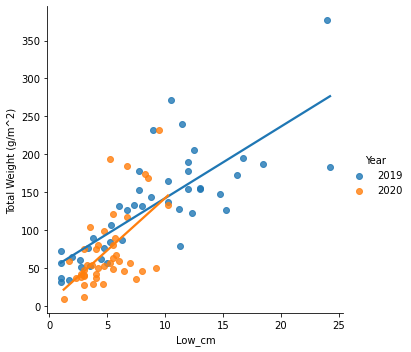

In [26]:
# plot linear fit of low VOR reading and Biomass
sns.lmplot(
    #x='High_cm', 
    x='Low_cm',
    y='Total Weight (g/m^2)',
    hue='Year', ci=None,
    data=df_wtgn_vor_agg)

In [27]:
df_wtgn_vor[df_wtgn_vor['Low_cm'] > 20]

,Pasture,Plot,Date,VOR position,High_cm,Low_cm,Total Weight (g/m^2)
160,North Owens - No PD,11,2019-07-23,east,37.0,23.0,122.34
183,North Owens - No PD,9,2019-07-24,south,63.0,23.0,136.88
184,North Owens - No PD,1,2019-07-24,south,43.0,34.0,376.64
196,North Owens - No PD,1,2019-07-24,east,59.0,28.0,376.64
233,East NE Weiss,5,2019-08-01,south,44.0,23.0,187.24
234,East NE Weiss,5,2019-08-01,north,40.0,21.0,187.24
235,East NE Weiss,5,2019-08-01,east,31.0,21.0,187.24
246,East NE Weiss,1,2019-08-01,north,53.0,43.0,183.44
248,East NE Weiss,2,2019-08-01,west,37.0,21.0,147.20
283,North School Section H,2,2019-08-12,south,52.0,26.0,172.62


In [28]:
df_wtgn_bm[(df_wtgn_bm['Pasture'] == 'W Weiss E') &
           (df_wtgn_bm['Plot'] == 5)][['Notes', 're-weighs']]

,Notes,re-weighs
132,NaN,NaN


In [30]:
# save final data to disk
df_wtgn_vor_agg.to_csv(os.path.join(os.getcwd(), outDIR_vor_train, 'TB_wtgn_vor_train.csv'), index=False)

In [30]:
import statsmodels.formula.api as smf
mod_both = smf.ols("Q('Total Weight (g/m^2)') ~ High_cm + Low_cm", data=df_wtgn_vor_agg).fit()

In [31]:
mod_both.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Q('Total Weight (g/m^2)')   R-squared:                       0.595
Model:                                   OLS   Adj. R-squared:                  0.585
Method:                        Least Squares   F-statistic:                     62.31
Date:                       Tue, 17 May 2022   Prob (F-statistic):           2.18e-17
Time:                               09:23:49   Log-Likelihood:                -455.59
No. Observations:                         88   AIC:                             917.2
Df Residuals:                             85   BIC:                             924.6
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.8513     12.966      0.837      0.405     -14.929      36.632
High_cm        1.2425      0.739      1.682      0.096      -0.226       2.711
Low_cm         9.1407      1.382      6.612      0.000       6.392      11.889
==============================================================================
Omnibus:                       13.472   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.808
Skew:                           0.854   Prob(JB):                     0.000609
Kurtosis:                       4.059   Cond. No.                         71.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""